In [13]:
import networkx as nx, matplotlib.pyplot as plt, pandas as pd
from karateclub import Diff2Vec, Role2Vec
from sklearn.manifold import TSNE
import numpy as np
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["address-clustering"]
transfers = db["transfers"]

In [14]:
# Fetch all documents from the 'transfers' collection
data = list(transfers.find({}, {"from": 1, "to": 1, "_id": 0}))

In [15]:
G = nx.Graph()

# Add edges to the graph
for transfer in data:
    G.add_edge(transfer['from'], transfer['to'])

In [17]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("First 5 nodes:", list(G.nodes)[:5])

Number of nodes: 1520251
Number of edges: 6163109
First 5 nodes: ['0x0000000000000000000000000000000000000000', '0x000000000d5a50614bcdf08700fe6ceb1c7dad4b', '0xeb5c52e8af57334fab0b5f3d888990c108545527', '0x000000085d9a759bb5c3d459d638739c0f48deb0', '0x9d551f41fed6fc27b719777c224dfecce170004d']


In [16]:
# Initialize Diff2Vec model
diff2vec = Diff2Vec(diffusion_number=2, diffusion_cover=20, dimensions=64)
diff2vec.fit(G)

# Get the embeddings
diff_embeddings = diff2vec.get_embedding()

# Initialize Role2Vec model
role2vec = Role2Vec(walk_number=10, walk_length=80, dimensions=64, workers=4)
role2vec.fit(G)

# Get the embeddings
role_embeddings = role2vec.get_embedding()

combined_embeddings = np.concatenate((diff_embeddings, role_embeddings), axis=1)

AssertionError: The node indexing is wrong.

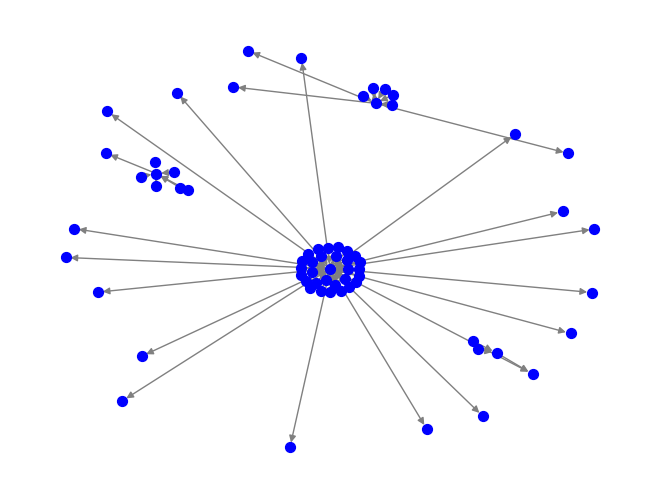

In [9]:
# nx.draw(G,
#         with_labels=False,
#         node_color="blue",
#         node_size=50,
#         edge_color="gray",
#         arrows= True)

In [ ]:
# Create an integer index for the 'from' and 'to' columns
addresses = pd.concat([df['from'], df['to']]).unique()
address_to_int = {address: i for i, address in enumerate(addresses)}

# Replace addresses with integer indices in 'from' and 'to' columns
df_transfers = df[['from', 'to']].replace(address_to_int)

# Create a directed graph from the dataframe
G = nx.from_pandas_edgelist(df_transfers, 'from', 'to', create_using=nx.DiGraph())

# Initialize Diff2Vec model
diff2vec = Diff2Vec(diffusion_number=2, diffusion_cover=20, dimensions=64)
diff2vec.fit(G)

# Get the embeddings
diff_embeddings = diff2vec.get_embedding()

# Initialize Role2Vec model
role2vec = Role2Vec(walk_number=10, walk_length=80, dimensions=64, workers=4)
role2vec.fit(G)

# Get the embeddings
role_embeddings = role2vec.get_embedding()

combined_embeddings = np.concatenate((diff_embeddings, role_embeddings), axis=1)

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2)
combined_embeddings_2d = tsne.fit_transform(combined_embeddings)

# Create a scatter plot
plt.figure(figsize=(10, 10))
plt.scatter(combined_embeddings_2d[:, 0], combined_embeddings_2d[:, 1])
plt.title('2D t-SNE of Combined Node Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()